## Importing all the Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import Likelihood, QuantileRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

from datetime import timedelta
#warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the Model

In [2]:
input_chunk_length = 50
output_chunk_length = 50  # Forecast horizon of 50 time steps

from pytorch_lightning.callbacks import Callback
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    # will automatically be called at the end of each epoch
    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))


loss_logger = LossLogger()

tft_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=128,
    n_epochs=50,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    pl_trainer_kwargs={"callbacks": [loss_logger]},
)


tft_model = tft_model.load("/home/vnk3019/RCP_TFT_11202023_nn.pt")


## Importing and Loading Data

In [3]:
def estimate_cold_pressure(Pmeas,Tmeas,Tcold):
    Patm = 1.01325 #bar
    
    Pcold = (Pmeas + Patm)*(Tcold+273.15)/(Tmeas + 273.15) - Patm
    
    return Pcold

def gazao_rate_model(temperature,pressure,E = 6000, tau0 = 1/3, tire_sw = 275, tire_sh = 80, tire_rim = 22.5):
    R = 8.314e-2 #L*bar/(K*mol) ideal gas constant
    T0 = 293.15 #tempoerature in kelvin
    
    #estimating the approximate volume available in the tire
    Vtire = tire_sw*(((2*tire_sw*tire_sh/100 + tire_rim*25.4)**2)*np.pi/4 - ((tire_rim*25.4)**2)*np.pi/4)*1e-6 #liters
    
    T_K = temperature + 273.15
    gazao_rate = (1/tau0)*np.exp(-E/T_K)*24*3600*pressure # in bar per day lost by diffusion
    
    # estimating the loss of mol of gas per day 
    n_est = gazao_rate*Vtire/R/T0
    
    return n_est

def repartition_static_load(total_load, WP = '1L',mount_type = 'dual'):
    #static load based on measurements at LPG for wheel force transducers
    #hard coded values based on fit parameters
    
    if WP[0] == '1':
        tire_pos_type = 'steer'
    elif WP[0] == '2' or WP[0]=='3':
        tire_pos_type = 'drive'
    elif WP[0] == '4' or WP[0]=='5':
        tire_pos_type = 'trailer'
    
    if tire_pos_type == 'steer':
        mount_type = 'single'
        wp_load =total_load*1445.5*total_load**-0.936
    elif tire_pos_type == 'drive':
        wp_load = total_load*0.041*total_load**0.0271
        if mount_type == 'xone':
            wp_load = 2*wp_load
    elif tire_pos_type == 'trailer':
        wp_load = total_load*(0.0343*np.log(total_load) - 0.3073)
        if mount_type == 'xone':
            wp_load = 2*wp_load
    return wp_load

def calc_nrg_from_classifier(clf,df,val_name):
    fts = [ 'P_avg_bar', 'avg_veh_speed_kph', 'wp_load_kg']
    df[val_name] = clf.predict(df[fts].values)    
    return df

example_df = pd.read_csv('Example_TimeSeries_Data_KR8833.bz2')

input_list = [x for x in list(example_df) if 'shear' not in x and 'nci' not in x and 'Insp_Damage' not in x]
output_list = [x for x in list(example_df) if x not in input_list]

# drum conditions 
Pinf_bar = 4.1
Load_kg = 1500
Speed_kph = 50
Start_Date = '2022-06-14'

tire_sn = 'AADB-0434'
study_type = 'DrumTesting_Condition5'

tire_type  = 'XLEZ 275/80R22.5'
#Time
freq_samp_hrs = 1 #sample per hour
rg_dates = pd.date_range(pd.to_datetime(Start_Date), pd.to_datetime(Start_Date) + timedelta(int(1e6/Speed_kph/24)),freq = str(freq_samp_hrs) + 'H')
test_df = pd.DataFrame(index = rg_dates)

# non-simulated data (although at this point temperature is estimated)

#age_days
test_df['age_days'] = (test_df.index - test_df.index[0])/timedelta(1)
#avg_speed_kph
test_df['avg_veh_speed_kph'] = Speed_kph
#casing_mileage_kms
test_df['delta_casing_mileage_kms'] = test_df.avg_veh_speed_kph*freq_samp_hrs
test_df['casing_mileage_kms'] = test_df.delta_casing_mileage_kms.cumsum()
#life_num
test_df['Life_Num'] = 1
#POS
test_df['POS'] = '1L'
#wp_load_kg
test_df['wp_load_kg'] = Load_kg
#P_avg_bar
test_df['P_avg_bar'] = Pinf_bar
#T_avg_degC
test_df['T_avg_degC'] = 50

#gazao modeling
test_df['n_rxns_per_hr'] = gazao_rate_model(test_df.T_avg_degC,test_df.P_avg_bar)/24
test_df['n_rxns_cumul'] = test_df.n_rxns_per_hr.cumsum()

#fill in the FEA metrics
rolling_radius = 498.2 #mm, simulation average among all conditions with little variation (taken from XLEZ)
Nrev_per_km = 1/(np.pi*2*rolling_radius*1e-6)
daNmm_to_kilajoule = 1e-5
clf_list = [x for x in os.listdir('./') if 'XLEZ' in x and 'NC_sidewall' in x]
clfs = [joblib.load('./' + x) for x in clf_list]
clf_name = ['_'.join(x.split('_')[1:5]) for x in clf_list]

for clf,clname in zip(clfs,clf_name):
    test_df = calc_nrg_from_classifier(clf,test_df,clname)
    if clname == 'NC_sidewall_SEelm_sumrev':
        #do a summamtion across the number of revolutions and the energy calculated, then convert the energy estimated to kilajoules
        test_df[clname] = (test_df[clname]*Nrev_per_km*test_df['avg_veh_speed_kph']*daNmm_to_kilajoule).cumsum()
test_df['Time'] = test_df.index
test_df.reset_index(drop = True, inplace = True)

In [4]:
def repartition_static_load(total_load, WP = '1L',mount_type = 'dual'):
    #static load based on measurements at LPG for wheel force transducers
    #hard coded values based on fit parameters
    
    if WP[0] == '1':
        tire_pos_type = 'steer'
    elif WP[0] == '2' or WP[0]=='3':
        tire_pos_type = 'drive'
    elif WP[0] == '4' or WP[0]=='5':
        tire_pos_type = 'trailer'
    
    if tire_pos_type == 'steer':
        mount_type = 'single'
        wp_load =total_load*1445.5*total_load**-0.936
    elif tire_pos_type == 'drive':
        wp_load = total_load*0.041*total_load**0.0271
        if mount_type == 'xone':
            wp_load = 2*wp_load
    elif tire_pos_type == 'trailer':
        wp_load = total_load*(0.0343*np.log(total_load) - 0.3073)
        if mount_type == 'xone':
            wp_load = 2*wp_load
    return wp_load


In [5]:
data = pd.read_csv("/home/vnk3019/Gaussian_Reduced_Data.csv")
data = data[data['Tire_ID']=='STX01']
data

,age_days,casing_mileage_kms,Life_Num,wp_load_kg,avg_veh_speed_kph,P_avg_bar,T_avg_degC,n_rxns_cumul,NC_sidewall_SEelm_sumrev,NC_sidewall_CVMD_AMP,NC_sidewall_maxCVMD_rev,predicted_RCP,Tire_ID
94464,-1.946798e-11,-2.381512e-08,1.0,2774.198264,92.292647,8.104516,30.362504,-0.003727,0.034646,0.005307,-0.010215,1.0,STX01
94465,7.537879e-01,9.225030e+02,1.0,2774.198264,96.633881,8.132641,31.509526,0.035728,2.399216,0.005262,-0.010207,1.0,STX01
94466,1.507576e+00,1.845006e+03,1.0,2774.198264,99.375608,8.134874,32.103528,0.073938,4.781447,0.005243,-0.010202,1.0,STX01
94467,2.261364e+00,2.767509e+03,1.0,2774.198264,100.819534,8.117553,32.263808,0.111058,7.178996,0.005243,-0.010199,1.0,STX01
94468,3.015152e+00,3.690012e+03,1.0,2774.198264,101.267369,8.087016,32.109662,0.147242,9.589520,0.005256,-0.010198,1.0,STX01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94603,1.036985e+03,5.809693e+05,2.0,1433.533497,100.000000,7.088238,28.239076,18.345957,1394.560087,0.004147,-0.010228,0.0,STX01
94604,1.037739e+03,5.817975e+05,2.0,1433.533497,100.000000,7.100940,28.503606,18.370075,1395.972147,0.004130,-0.010228,0.0,STX01
94605,1.038492e+03,5.826258e+05,2.0,1433.533497,100.000000,7.128110,29.043486,18.394368,1397.383540,0.004090,-0.010228,0.0,STX01
94606,1.039246e+03,5.834540e+05,2.0,1433.533497,100.000000,7.173065,29.913009,18.418895,1398.794042,0.004022,-0.010229,0.0,STX01


In [6]:
tire_data = data[['age_days', 'avg_veh_speed_kph', 
       'casing_mileage_kms', 'Life_Num', 'wp_load_kg', 'P_avg_bar',
       'T_avg_degC', 'n_rxns_cumul']]
tire_data['P_avg_bar'] = 7
tire_data['T_avg_degC'] = 35
tire_data['avg_veh_speed_kph'] = 100


# Define a function to apply to the 'casing_mileage_kms' to determine 'Life_Num'
def assign_life_num(mileage):
    if 0 <= mileage <= 250000:
        return 1
    elif 250000 < mileage <= 500000:
        return 2
    else:
        return 3  # Or some other value for mileages outside the specified range

tire_data['Life_Num'] = tire_data['casing_mileage_kms'].apply(assign_life_num)


tire_data

,age_days,avg_veh_speed_kph,casing_mileage_kms,Life_Num,wp_load_kg,P_avg_bar,T_avg_degC,n_rxns_cumul
94464,-1.946798e-11,100,-2.381512e-08,3,2774.198264,7,35,-0.003727
94465,7.537879e-01,100,9.225030e+02,1,2774.198264,7,35,0.035728
94466,1.507576e+00,100,1.845006e+03,1,2774.198264,7,35,0.073938
94467,2.261364e+00,100,2.767509e+03,1,2774.198264,7,35,0.111058
94468,3.015152e+00,100,3.690012e+03,1,2774.198264,7,35,0.147242
...,...,...,...,...,...,...,...,...
94603,1.036985e+03,100,5.809693e+05,3,1433.533497,7,35,18.345957
94604,1.037739e+03,100,5.817975e+05,3,1433.533497,7,35,18.370075
94605,1.038492e+03,100,5.826258e+05,3,1433.533497,7,35,18.394368
94606,1.039246e+03,100,5.834540e+05,3,1433.533497,7,35,18.418895


## Surrogate FEM model to find Energy state and internal energy 

In [7]:
# The function that encapsulates the modeling process
def perform_modeling(df):
    # Applying the gazao_rate_model
    df['n_rxns_per_hr'] = gazao_rate_model(df.T_avg_degC, df.P_avg_bar) / 24
    df['n_rxns_cumul'] = df.n_rxns_per_hr.cumsum()

    # Constants
    rolling_radius = 498.2  # mm, simulation average among all conditions
    Nrev_per_km = 1 / (np.pi * 2 * rolling_radius * 1e-6)
    daNmm_to_kilajoule = 1e-5

    # Placeholder for actual classifier files and joblib loading process.
    clf_list = [x for x in os.listdir('./') if 'XLEZ' in x and 'NC_sidewall' in x]
    clfs = [joblib.load('./' + x) for x in clf_list]
    clf_name = ['_'.join(x.split('_')[1:5]) for x in clf_list]

    # Calculating energy from classifiers
    for clf, clname in zip(clfs, clf_name):
        df = calc_nrg_from_classifier(clf, df, clname)
        if clname == 'NC_sidewall_SEelm_sumrev':
            # Summation across the number of revolutions and the energy calculated, convert to kilajoules
            df[clname] = (df[clname] * Nrev_per_km * df['avg_veh_speed_kph'] * daNmm_to_kilajoule).cumsum() *45

    # Setting 'Time' column to be the index of the DataFrame
    df['Time'] = df.index
    df.reset_index(drop=True, inplace=True)

    return df

In [8]:
# Function to change tire location based on mileage and location
def change_tire_location(df, total_load, start_mileage, end_mileage, perform_modeling, new_location):
    # Selecting the rows where tire needs to be changed based on the mileage
    df_to_change = df[(df['casing_mileage_kms'] >= start_mileage) & (df['casing_mileage_kms'] <= end_mileage)]
    
    # Change the tire location for selected rows
    df.loc[df_to_change.index, 'wp_load_kg'] = repartition_static_load(total_load, WP = new_location,mount_type = 'dual')

    df = perform_modeling(df)
    index = df_to_change.index[-1]
    
    return df, index

# Assuming we have to change tire location from '1L' to '2L' between 200 and 250 kms
tire_data_changed_1 = change_tire_location(tire_data, 36000, start_mileage=0, end_mileage=1000000, perform_modeling = perform_modeling, new_location='4L0')

In [9]:
# Function to change tire location and perform time series forecasting
def change_location_and_forecast(df, total_load, start_mileage, end_mileage, new_location, tft_model, RCP_start = 1):
    # Change tire location based on mileage and perform modeling
    df, index = change_tire_location(df, total_load, start_mileage, end_mileage, perform_modeling, new_location)
    
    # Prepare the DataFrame for forecasting
    df_rcp_cov = df[['Life_Num', 'NC_sidewall_CVMD_AMP', 'NC_sidewall_SEelm_sumrev',
                     'NC_sidewall_maxCVMD_rev', 'P_avg_bar', 'T_avg_degC', 'age_days',
                     'avg_veh_speed_kph', 'casing_mileage_kms', 'n_rxns_cumul',
                     'wp_load_kg']]

    
    # Create a DataFrame for the series
    df_rcp_ser = pd.DataFrame({'Column1': [RCP_start] * 50})
    
    # Convert DataFrames to TimeSeries objects
    darts_rcp_cov = TimeSeries.from_dataframe(df_rcp_cov).astype(np.float32)
    darts_rcp_ser = TimeSeries.from_dataframe(df_rcp_ser).astype(np.float32)
    
    # Forecast using the pre-trained model
    Remaining_RCP = tft_model.predict(n=darts_rcp_cov.time_index.stop-100, series=darts_rcp_ser, future_covariates=darts_rcp_cov, num_samples=50, verbose=False)
    
    return Remaining_RCP[index].values()

# Correct function call
RCP = change_location_and_forecast(tire_data, 36000, 0, 300000, '1LO', tft_model)
float(RCP)

0.18439994752407074

In [10]:
x = np.linspace(1000, 300000, 5)
RCP_reduction_list = []

for end_dist in tqdm(x):
    end_dist_value = int(end_dist)
    RCP = change_location_and_forecast(tire_data, 36000, 0, end_dist_value, '2LO', tft_model)
    RCP_reduction_list.append(float(RCP))


  0%|          | 0/5 [00:00<?, ?it/s]

Mileage Steps: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


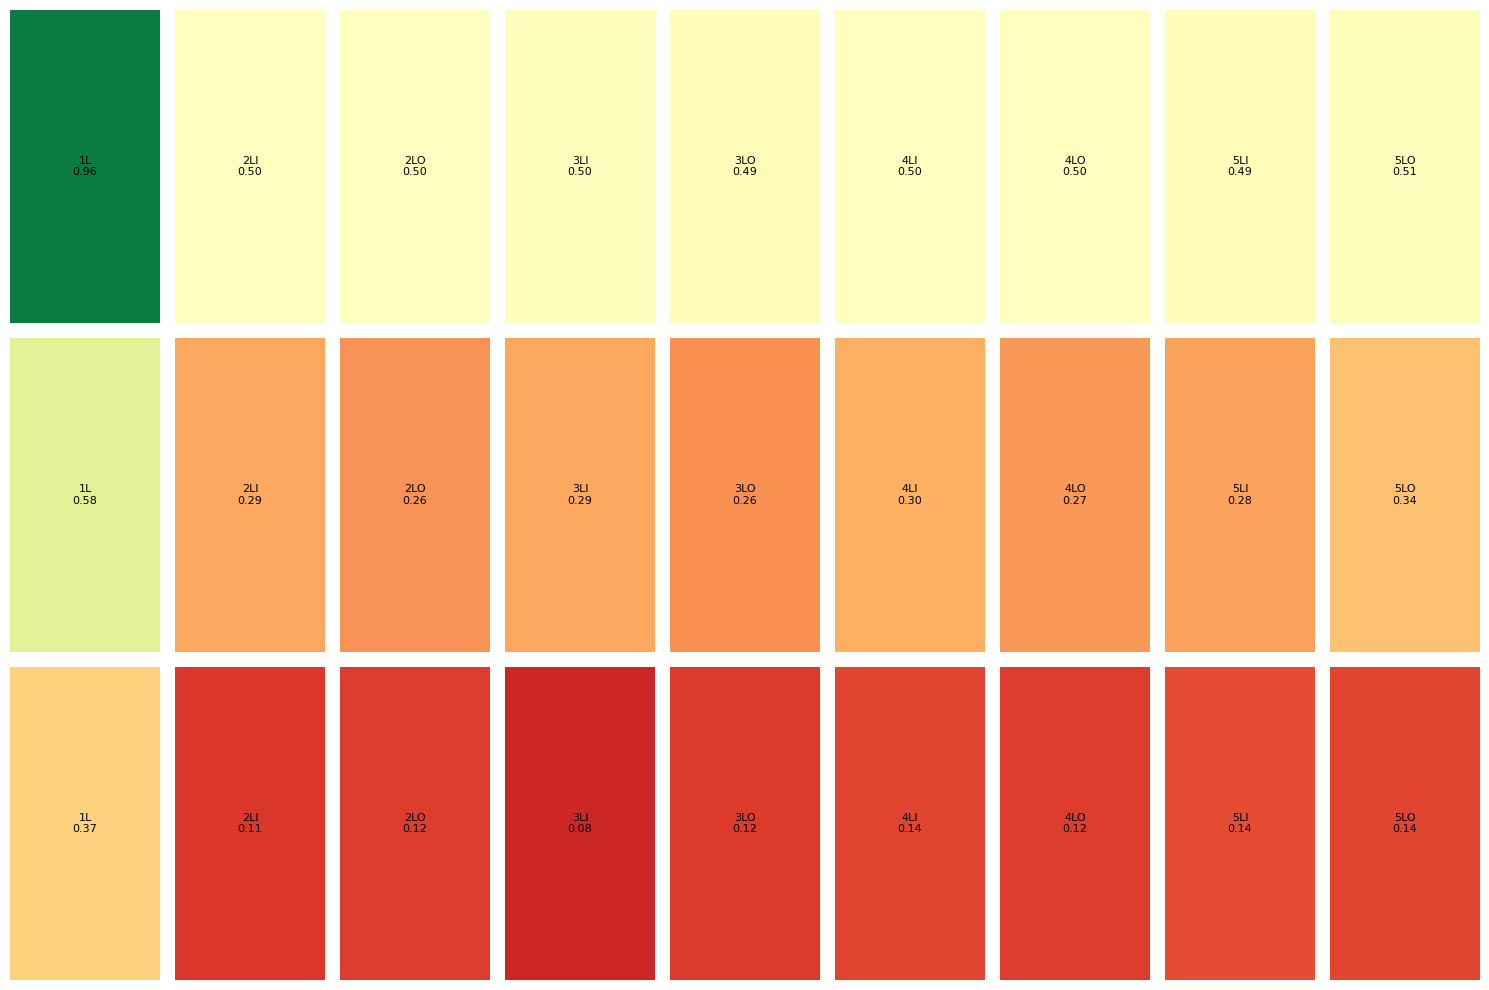

In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define tire locations
tire_locations = ['1L', '2LI', '2LO', '3LI', '3LO', '4LI', '4LO', '5LI', '5LO']

# Mileage steps from 100 to 100000 with 5 steps
mileage_steps = np.linspace(1000, 300000, 3)

# Initialize a DataFrame to store RCP predictions with an extra 'Mileage' column
columns = ['Mileage'] + tire_locations
rcp_predictions = pd.DataFrame(columns=columns)

# Iterate over each mileage step and each tire location
for end_mileage in tqdm(mileage_steps, desc="Mileage Steps"):
    rcp_row = {'Mileage': end_mileage}
    for location in tire_locations:

        # Adjust RCP_start based on location
        RCP_start = 1 if location == '1L' else 0.5

        # Call the forecasting function for each combination of location and mileage step
        RCP = change_location_and_forecast(tire_data, 10, 0, int(end_mileage), location, tft_model, RCP_start=RCP_start)
        
        # Assuming RCP returns a numeric value or an object from which a numeric value can be extracted
        rcp_row[location] = float(RCP)  # Replace RCP with the appropriate value extraction if necessary
    
    # Append the row to the DataFrame
    rcp_predictions = rcp_predictions.append(rcp_row, ignore_index=True)

# Display the resulting DataFrame
data_dict = rcp_predictions.set_index('Mileage').T.to_dict('list')
data_dict

# Convert the provided dictionary to the desired dictionary format
data = {"Mileage": list(data_dict.keys())}
for i, loc in enumerate(tire_locations):
    data[loc] = [values[i] for values in data_dict.values()]

# Now, `data` is in the desired format
import matplotlib.pyplot as plt
import numpy as np

# Assuming data has been provided in the same structure as before.

# Normalize the values to map to the colormap
norm = plt.Normalize(0, 1)
mapper = plt.cm.ScalarMappable(norm=norm, cmap='RdYlGn')

# Setting up the figure and axes
fig, axs = plt.subplots(len(data['Mileage']), len(data) - 1, figsize=(15, 10))

# Loop through each mileage step
for i, mileage in enumerate(data['Mileage']):
    for j, (location, values) in enumerate(data.items()):
        if location == 'Mileage':
            continue  # Skip the mileage column
        
        # Get the value corresponding to the current mileage step
        val = values[i]
        
        # Get the color from the color map
        color = mapper.to_rgba(val)
        
        # Plot the colored cell
        axs[i, j - 1].add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
        axs[i, j - 1].text(0.5, 0.5, f'{location}\n{val:.2f}', ha='center', va='center', fontsize=8, color='black')
        
        # Turn off the axis
        axs[i, j - 1].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
data

{'Mileage': [1000.0, 150500.0, 300000.0],
 '1L': [0.9576950073242188, 0.5779836773872375, 0.3720986843109131],
 '2LI': [0.5002011060714722, 0.2891167998313904, 0.11290249973535538],
 '2LO': [0.5023322105407715, 0.26127323508262634, 0.1230154037475586],
 '3LI': [0.5043764710426331, 0.2903784513473511, 0.07972534000873566],
 '3LO': [0.4870615005493164, 0.25664517283439636, 0.1200113296508789],
 '4LI': [0.4998661279678345, 0.30117666721343994, 0.13667032122612],
 '4LO': [0.4994365870952606, 0.26647770404815674, 0.12114288657903671],
 '5LI': [0.4921290874481201, 0.2840675711631775, 0.14478956162929535],
 '5LO': [0.5070306062698364, 0.33706676959991455, 0.13652078807353973]}

Mileage Steps: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


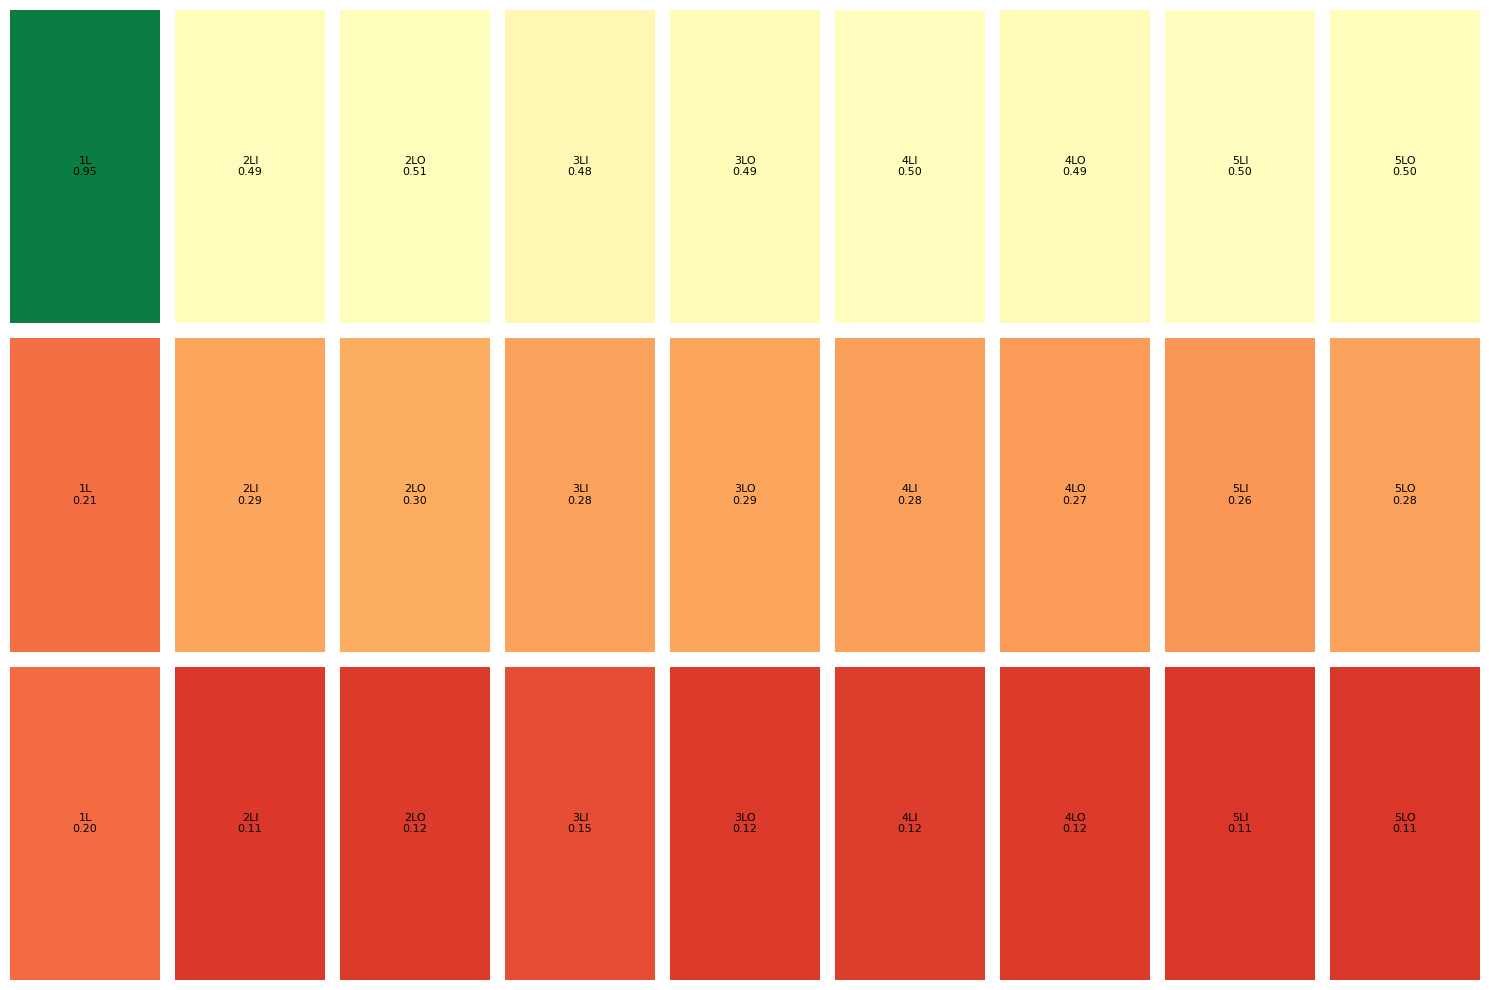

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define tire locations
tire_locations = ['1L', '2LI', '2LO', '3LI', '3LO', '4LI', '4LO', '5LI', '5LO']

# Mileage steps from 100 to 100000 with 5 steps
mileage_steps = np.linspace(1000, 300000, 3)

# Initialize a DataFrame to store RCP predictions with an extra 'Mileage' column
columns = ['Mileage'] + tire_locations
rcp_predictions = pd.DataFrame(columns=columns)

# Iterate over each mileage step and each tire location
for end_mileage in tqdm(mileage_steps, desc="Mileage Steps"):
    rcp_row = {'Mileage': end_mileage}
    for location in tire_locations:

        # Adjust RCP_start based on location
        RCP_start = 1 if location == '1L' else 0.5

        # Call the forecasting function for each combination of location and mileage step
        RCP = change_location_and_forecast(tire_data, 36000, 0, int(end_mileage), location, tft_model, RCP_start=RCP_start)
        
        # Assuming RCP returns a numeric value or an object from which a numeric value can be extracted
        rcp_row[location] = float(RCP)  # Replace RCP with the appropriate value extraction if necessary
    
    # Append the row to the DataFrame
    rcp_predictions = rcp_predictions.append(rcp_row, ignore_index=True)

# Display the resulting DataFrame
data_dict = rcp_predictions.set_index('Mileage').T.to_dict('list')
data_dict

# Convert the provided dictionary to the desired dictionary format
data = {"Mileage": list(data_dict.keys())}
for i, loc in enumerate(tire_locations):
    data[loc] = [values[i] for values in data_dict.values()]

# Now, `data` is in the desired format
import matplotlib.pyplot as plt
import numpy as np

# Assuming data has been provided in the same structure as before.

# Normalize the values to map to the colormap
norm = plt.Normalize(0, 1)
mapper = plt.cm.ScalarMappable(norm=norm, cmap='RdYlGn')

# Setting up the figure and axes
fig, axs = plt.subplots(len(data['Mileage']), len(data) - 1, figsize=(15, 10))

# Loop through each mileage step
for i, mileage in enumerate(data['Mileage']):
    for j, (location, values) in enumerate(data.items()):
        if location == 'Mileage':
            continue  # Skip the mileage column
        
        # Get the value corresponding to the current mileage step
        val = values[i]
        
        # Get the color from the color map
        color = mapper.to_rgba(val)
        
        # Plot the colored cell
        axs[i, j - 1].add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
        axs[i, j - 1].text(0.5, 0.5, f'{location}\n{val:.2f}', ha='center', va='center', fontsize=8, color='black')
        
        # Turn off the axis
        axs[i, j - 1].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Two different trucks

In [13]:
total_load_truck_1 = 16000
total_load_truck_2 = 36000

change_location_and_forecast(tire_data, total_load_truck_1, 0, int(end_mileage), location, tft_model)


array([[0.30620757]], dtype=float32)

In [23]:
y

{('1L', 0, 1, 1, 2): tire_change_('1L',_0,_1,_1,_2),
 ('1L', 0, 1, 2, 1): tire_change_('1L',_0,_1,_2,_1),
 ('1L', 0, 2, 1, 2): tire_change_('1L',_0,_2,_1,_2),
 ('1L', 0, 2, 2, 1): tire_change_('1L',_0,_2,_2,_1),
 ('1L', 0, 3, 1, 2): tire_change_('1L',_0,_3,_1,_2),
 ('1L', 0, 3, 2, 1): tire_change_('1L',_0,_3,_2,_1),
 ('1L', 0, 4, 1, 2): tire_change_('1L',_0,_4,_1,_2),
 ('1L', 0, 4, 2, 1): tire_change_('1L',_0,_4,_2,_1),
 ('1L', 0, 5, 1, 2): tire_change_('1L',_0,_5,_1,_2),
 ('1L', 0, 5, 2, 1): tire_change_('1L',_0,_5,_2,_1),
 ('1L', 0, 6, 1, 2): tire_change_('1L',_0,_6,_1,_2),
 ('1L', 0, 6, 2, 1): tire_change_('1L',_0,_6,_2,_1),
 ('1L', 0, 7, 1, 2): tire_change_('1L',_0,_7,_1,_2),
 ('1L', 0, 7, 2, 1): tire_change_('1L',_0,_7,_2,_1),
 ('1L', 0, 8, 1, 2): tire_change_('1L',_0,_8,_1,_2),
 ('1L', 0, 8, 2, 1): tire_change_('1L',_0,_8,_2,_1),
 ('1L', 0, 9, 1, 2): tire_change_('1L',_0,_9,_1,_2),
 ('1L', 0, 9, 2, 1): tire_change_('1L',_0,_9,_2,_1),
 ('1L', 0, 10, 1, 2): tire_change_('1L',_0,_10

In [78]:
import pulp

# Initialize the optimization problem
problem = pulp.LpProblem("Tire_Resource_Allocation", pulp.LpMaximize)

# Define the sets of trucks, locations, mileages, and tires
trucks = [1, 2]  # Example for two trucks
locations = ['1L', '2LI', '2LO', '3LI', '3LO', '4LI', '4LO', '5LI', '5LO']
mileages = range(1000, 300001, 50000)  # From 1,000 to 300,000 with steps of 50,000
tires = range(1, len(locations) * len(trucks) + 1)  # Unique identifier for each tire

# Decision Variables
# x[k, l, m, t]: 1 if tire k is placed at location l, at mileage m, on truck t; 0 otherwise
x = pulp.LpVariable.dicts("tire_placement",
                          ((k, l, m, t) for k in tires for l in locations for m in mileages for t in trucks),
                          cat='Binary')
# y[k, l, m, t, tp]: 1 if tire k is moved from location l, from truck t to truck tp at mileage m; 0 otherwise
# Note: This formulation assumes tires can move between trucks, not between locations within the same truck
y = pulp.LpVariable.dicts("tire_change",
                          ((k, l, m, t, tp) for k in tires for l in locations for m in mileages for t in trucks for tp in trucks if t != tp),
                          cat='Binary')

# Assume RCP_start values based on location
RCP_start_values = {'1L': 1.0}  # Starting RCP for steer tire location
default_RCP_start = 0.5  # Default starting RCP for other locations

# Dynamically calculate RCP values based on the forecasting function and starting RCP
RCP_values = {}
for k in tires:
    for l in locations:
        for m in mileages:
            # Determine the starting RCP based on the tire location
            RCP_start = RCP_start_values.get(l, default_RCP_start)
            
            # Calculate the RCP using your forecasting function
            RCP = change_location_and_forecast(tire_data, 36000, 0, int(m), l, tft_model, RCP_start=RCP_start)
            RCP_values[(k, l, m)] = RCP

# Objective Function: Maximize total RCP using the dynamically calculated values
problem += pulp.lpSum([RCP_values[(k, l, m)] * x[k, l, m, t] for k in tires for l in locations for m in mileages for t in trucks]), "Total_RCP"

# Constraints
# Each tire must be in exactly one location on any truck at each mileage step
for k in tires:
    for m in mileages:
        problem += pulp.lpSum([x[k, l, m, t] for l in locations for t in trucks]) == 1, f"Tire_{k}_Placement_{m}"

for k in tires:
    for l in locations:
        for m in mileages:
            for t in trucks:
                # Create a constraint for each tire, location, mileage, and truck
                # Ensure that a tire is not placed if its RCP is below the threshold
                # This is indirectly enforced by not allowing the tire placement variable to be 1
                # if the RCP is below the threshold, hence avoiding the use of unsupported operations
                if RCP_values[(k, l, m)] <= RCP_threshold:
                    problem += x[k, l, m, t] == 0, f"Scrapping_Tire_{k}_{l}_{m}_{t}"

# Ensure each location on each truck has exactly one tire at all mileage points
for l in locations:
    for m in mileages:
        for t in trucks:
            # Sum over all tires for this location, truck, and mileage
            # The sum should be exactly 1, indicating exactly one tire is allocated here
            problem += pulp.lpSum([x[k, l, m, t] for k in tires]) == 1, f"Location_{l}_Truck_{t}_Mileage_{m}_Has_Tire"

# Solve the problem
problem.solve()

# Output the results
for v in problem.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/vnk3019/miniconda3/envs/darts_env/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/20ec7780e27a4ca7b6093d8828cc95b7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/20ec7780e27a4ca7b6093d8828cc95b7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 243 COLUMNS
At line 9986 RHS
At line 10225 BOUNDS
At line 12170 ENDATA
Problem MODEL has 238 rows, 1944 columns and 3910 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 39.6669 - 0.01 seconds
Cgl0002I 22 variables fixed
Cgl0004I processed model has 216 rows, 1922 columns (1922 integer (1922 of which binary)) and 3844 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -39.6669
Cbc0038I Before mini branch and bound, 1922 integers at bound fixed and 0 continuous
C

In [79]:
# Check the status of the solution
status = problem.status
print("Status:", pulp.LpStatus[status])

if status == pulp.LpStatusOptimal:
    print("An optimal solution has been found.")
else:
    print("Optimal solution not found. Status is", pulp.LpStatus[status])


Status: Optimal
An optimal solution has been found.


In [80]:
# Assuming an optimal solution was found, extract the decisions
status = problem.status
if status == pulp.LpStatusOptimal:
    # Corrected iteration to match the modified x variable structure
    for k in tires:
        for l in locations:
            for m in mileages:
                for t in trucks:
                    # Correctly access x with the full key, including the tire identifier
                    if x[k, l, m, t].varValue is not None and x[k, l, m, t].varValue > 0:
                        print(f"Tire {k} at location {l} on truck {t} is used at mileage {m}.")

    # Iteration for tire movements, considering the y variable structure
    for k in tires:
        for l in locations:
            for m in mileages:
                for t in trucks:
                    for tp in trucks:
                        if t != tp:  # Ensure we're looking at movements between different trucks
                            # Correctly access y with the full key, including both source and destination trucks
                            if y[k, l, m, t, tp].varValue is not None and y[k, l, m, t, tp].varValue > 0:
                                print(f"Tire {k} moved from truck {t} to {tp} at location {l} and mileage {m}.")


Tire 1 at location 1L on truck 2 is used at mileage 1000.
Tire 1 at location 1L on truck 2 is used at mileage 201000.
Tire 1 at location 2LO on truck 2 is used at mileage 101000.
Tire 1 at location 3LI on truck 2 is used at mileage 51000.
Tire 1 at location 3LO on truck 1 is used at mileage 251000.
Tire 1 at location 4LI on truck 1 is used at mileage 151000.
Tire 2 at location 2LI on truck 2 is used at mileage 51000.
Tire 2 at location 3LI on truck 2 is used at mileage 1000.
Tire 2 at location 3LO on truck 2 is used at mileage 151000.
Tire 2 at location 4LO on truck 1 is used at mileage 101000.
Tire 2 at location 4LO on truck 2 is used at mileage 201000.
Tire 2 at location 5LO on truck 2 is used at mileage 251000.
Tire 3 at location 2LI on truck 1 is used at mileage 51000.
Tire 3 at location 2LO on truck 2 is used at mileage 1000.
Tire 3 at location 2LO on truck 1 is used at mileage 101000.
Tire 3 at location 3LI on truck 2 is used at mileage 151000.
Tire 3 at location 3LI on truck 2 i

In [81]:
if status == pulp.LpStatusOptimal:
    # Directly check each y variable to diagnose the issue
    for k in tires:
        for l in locations:
            for m in mileages:
                for t in trucks:
                    for tp in trucks:
                        if t != tp:  # Ensure we're looking at movements between different trucks
                            variable = y.get((k, l, m, t, tp), None)
                            if variable is not None and variable.varValue == 1:
                                print(f"Detected tire {k} movement from truck {t} to {tp} at location {l} and mileage {m}.")


In [82]:
# Assuming an optimal solution was found, extract the decisions
status = problem.status
if status == pulp.LpStatusOptimal:
    print("Tire placements:")
    for k in tires:
        for l in locations:
            for m in mileages:
                for t in trucks:
                    # Check if the tire is placed at this location on this truck at this mileage
                    if x[k, l, m, t].varValue is not None and x[k, l, m, t].varValue > 0:
                        print(f"Tire {k} is at location {l} on truck {t} at mileage {m}.")

    print("\nTire movements:")
    for k in tires:
        for l in locations:
            for m in mileages:
                for t in trucks:
                    for tp in trucks:
                        if t != tp:  # Looking at movements between different trucks
                            # Check if the tire is moved from this truck to another at this location and mileage
                            if y[k, l, m, t, tp].varValue is not None and y[k, l, m, t, tp].varValue > 0:
                                print(f"Tire {k} moved from truck {t} to truck {tp} from location {l} at mileage {m}.")


Tire placements:
Tire 1 is at location 1L on truck 2 at mileage 1000.
Tire 1 is at location 1L on truck 2 at mileage 201000.
Tire 1 is at location 2LO on truck 2 at mileage 101000.
Tire 1 is at location 3LI on truck 2 at mileage 51000.
Tire 1 is at location 3LO on truck 1 at mileage 251000.
Tire 1 is at location 4LI on truck 1 at mileage 151000.
Tire 2 is at location 2LI on truck 2 at mileage 51000.
Tire 2 is at location 3LI on truck 2 at mileage 1000.
Tire 2 is at location 3LO on truck 2 at mileage 151000.
Tire 2 is at location 4LO on truck 1 at mileage 101000.
Tire 2 is at location 4LO on truck 2 at mileage 201000.
Tire 2 is at location 5LO on truck 2 at mileage 251000.
Tire 3 is at location 2LI on truck 1 at mileage 51000.
Tire 3 is at location 2LO on truck 2 at mileage 1000.
Tire 3 is at location 2LO on truck 1 at mileage 101000.
Tire 3 is at location 3LI on truck 2 at mileage 151000.
Tire 3 is at location 3LI on truck 2 at mileage 201000.
Tire 3 is at location 5LO on truck 1 at mi

In [88]:
# Assume a specific mileage point for visualization
specific_mileage = 1000   # Example mileage point for visualization

# Initialize a matrix (or rather a dictionary for dynamic access) to store the allocation
# Key: (Truck, Location), Value: Tire ID
allocation_matrix = {}

# Populate the matrix based on the optimization solution
for k in tires:
    for l in locations:
        for t in trucks:
            if x[k, l, specific_mileage, t].varValue is not None and x[k, l, specific_mileage, t].varValue > 0:
                allocation_matrix[(t, l)] = k  # Assign tire to location on truck

# Print the matrix in a structured form
print(f"Tire Allocation at Mileage {specific_mileage}:")
for t in trucks:
    print(f"Truck {t}:")
    for l in locations:
        tire_id = allocation_matrix.get((t, l), 'None')  # Get the tire ID or 'None' if no tire is allocated
        print(f"  Location {l}: Tire {tire_id}")


Tire Allocation at Mileage 1000:
Truck 1:
  Location 1L: Tire 13
  Location 2LI: Tire 9
  Location 2LO: Tire 7
  Location 3LI: Tire 11
  Location 3LO: Tire 18
  Location 4LI: Tire 16
  Location 4LO: Tire 17
  Location 5LI: Tire 10
  Location 5LO: Tire 12
Truck 2:
  Location 1L: Tire 1
  Location 2LI: Tire 15
  Location 2LO: Tire 3
  Location 3LI: Tire 2
  Location 3LO: Tire 6
  Location 4LI: Tire 5
  Location 4LO: Tire 4
  Location 5LI: Tire 8
  Location 5LO: Tire 14


In [84]:
if problem.status == pulp.LpStatusOptimal:
    total_RCP = sum(RCP_values[(k, l, m)] * x[k, l, m, t].varValue 
                    for k in tires for l in locations for m in mileages for t in trucks 
                    if x[k, l, m, t].varValue > 0)
    print(f"Total RCP for the optimal solution: {total_RCP}")


Total RCP for the optimal solution: [[39.66688]]


In [98]:
def analyze_tire_movements_and_rcp(tire_id):
    if problem.status == pulp.LpStatusOptimal:
        print(f"Movements and RCP for Tire {tire_id}:")

        results = []

        # Collect placement information
        for l in locations:
            for m in mileages:
                for t in trucks:
                    if x[tire_id, l, m, t].varValue is not None and x[tire_id, l, m, t].varValue > 0:
                        rcp_value = RCP_values[(tire_id, l, m)]
                        results.append((m, f"At mileage {m}, Tire {tire_id} is placed at location {l} on Truck {t} with RCP: {rcp_value}"))

        # Collect movement information
        for l in locations:
            for m in mileages:
                for t in trucks:
                    for tp in trucks:
                        if t != tp and y[tire_id, l, m, t, tp].varValue is not None and y[tire_id, l, m, t, tp].varValue > 0:
                            results.append((m, f"At mileage {m}, Tire {tire_id} moved from Truck {t} to Truck {tp} from location {l}"))

        # Sort results by mileage and print
        for _, result in sorted(results, key=lambda x: x[0]):
            print(result)
    else:
        print("Solution is not optimal or not solved.")

# Example usage:
analyze_tire_movements_and_rcp(3)  # Analyze movements and RCP for tire 2


Movements and RCP for Tire 3:
At mileage 1000, Tire 3 is placed at location 2LO on Truck 2 with RCP: [[0.522873]]
At mileage 51000, Tire 3 is placed at location 2LI on Truck 1 with RCP: [[0.3841966]]
At mileage 101000, Tire 3 is placed at location 2LO on Truck 1 with RCP: [[0.3992712]]
At mileage 151000, Tire 3 is placed at location 3LI on Truck 2 with RCP: [[0.3120558]]
At mileage 201000, Tire 3 is placed at location 3LI on Truck 2 with RCP: [[0.33926544]]
At mileage 251000, Tire 3 is placed at location 5LO on Truck 1 with RCP: [[0.12782413]]


In [99]:
# RCP values for each tire, location, and mileage
# Format: RCP_values[(tire, location, mileage)] = RCP value
RCP_values = {
    (1, 'Steer', 1000): 0.9,
    (1, 'Drive', 1000): 0.8,
    (1, 'Trailer', 1000): 0.7,
    (2, 'Steer', 1000): 0.85,
    (2, 'Drive', 1000): 0.75,
    (2, 'Trailer', 1000): 0.65,
    # Similarly for mileage 2000, for brevity, let's assume they are slightly lower due to wear
    (1, 'Steer', 2000): 0.88,
    (1, 'Drive', 2000): 0.78,
    (1, 'Trailer', 2000): 0.68,
    (2, 'Steer', 2000): 0.83,
    (2, 'Drive', 2000): 0.73,
    (2, 'Trailer', 2000): 0.63,
}

# Example decision (placement) for tires at mileage 1000 for demonstration
# Assume Tire 1 is placed at 'Steer', Tire 2 at 'Drive' for Truck 1 at mileage 1000
# This is a simplification for demonstration purposes
tire_placement = {
    (1, 'Steer', 1000, 1): 1,
    (2, 'Drive', 1000, 1): 1,
}

# Calculate total RCP for this simple scenario
total_RCP = sum(
    RCP_values[(tire, loc, 1000)] for (tire, loc, mileage, truck), placed in tire_placement.items() if placed
)

print(f"Total RCP for the given tire placements at mileage 1000: {total_RCP}")


Total RCP for the given tire placements at mileage 1000: 1.65
